<a href="https://colab.research.google.com/github/sabvz-run/solarium_siep/blob/main/notebooks/Solarium_SIEP_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ☀️ Solarium SIEP
## Sistema Inteligente de Estimativa de Produtividade Solar

**Projeto:** A3 - 2025.2  
**Disciplina:** Sistemas de Controle e Inteligência Artificial  
**Curso:** Engenharia da Computação  
**Professor:** Noberto Maciel

**Equipe:**
- [Demerson Sampaio - 12725235937]
- [Josué Serra - 12724147248]
- [Rian Assis - 1272418628]
- [Sabrina Oliveira - 12725234634]

## Objetivos do Projeto
### Módulo 1: Predição de Geração
Desenvolver um modelo preditivo capaz de estimar a geração de energia solar (MW) com alta precisão, utilizando dados reais de irradiância, temperatura e condições operacionais da planta.

**Técnicas utilizadas:**
- Random Forest Regressor
- Gradient Boosting Regressor
- Análise Exploratória de Dados (EDA)
- Normalização e criação de features temporais
- Avaliação por MAE, RMSE e R²
- Lógica Fuzzy para análise de eficiência térmica dos painéis

### Módulo 2: Sistema de Recomendações
A partir das previsões do modelo e da eficiência estimada via Fuzzy, o sistema gera orientações automáticas, incluindo:

- Melhor momento para armazenar energia em baterias
- Quando vender energia excedente para a rede
- Quando economizar devido à baixa geração prevista
- Sugestão do horário ideal para uso de cargas de alto consumo


## Datasets Utilizados
O projeto utilizou exclusivamente os arquivos do Dataset 4, que reúne dados integrados de geração, clima e consumo:

| # | Dataset            | Período   | Uso                                  |
| - | ------------------ | --------- | ------------------------------------ |
| 1 | geracao_treino.csv | 2017–2020 | Treinamento (geração solar)          |
| 2 | geracao_teste.csv  | 2020      | Teste do modelo                      |
| 3 | clima_treino.csv   | 2017–2020 | Variáveis meteorológicas             |
| 4 | consumo_treino.csv | 2017–2020 | Consumo elétrico para recomendações  |
| 5 | consumo_teste.csv  | 2020      | Validação do módulo de recomendações |


Detalhes: [/datasets/README.md](https://github.com/sabvz-run/solarium_siep/tree/main/datasets)

---
**Repositório GitHub:** https://github.com/sabvz-run/solarium_siep  



MODULO 1

In [117]:
# ============================================================================
#                 INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS
# ============================================================================

# Instalacao de bibliotecas necessarias
import sys
print("Instalando bibliotecas...")
!pip install scikit-fuzzy -q

# Importacoes basicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Logica Fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Configuracoes de visualizacao
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")

Instalando bibliotecas...
Bibliotecas importadas com sucesso!


In [118]:
# ============================================================================
#         CARREGAMENTO DOS DATASETS (DATASET 4 - ELECTRICITY DEMAND)
# ============================================================================

print("\n" + "="*80)
print("CARREGANDO DATASETS")
print("="*80)

url_base = 'https://raw.githubusercontent.com/sabvz-run/solarium_siep/main/datasets/'

print("\n Dataset 4 - Electricity Demand")

# Dataset 4.1: Geracao Treino
print("\n[1/5] geracao_treino.csv")
try:
    df_geracao_treino = pd.read_csv(url_base + 'geracao_treino.csv')
    print(f"    Carregado: {df_geracao_treino.shape[0]} linhas, {df_geracao_treino.shape[1]} colunas")
except Exception as e:
    print(f"    ERRO: {e}")
    sys.exit(1)

# Dataset 4.2: Geracao Teste
print("\n[2/5] geracao_teste.csv")
try:
    df_geracao_teste = pd.read_csv(url_base + 'geracao_teste.csv')
    print(f"    Carregado: {df_geracao_teste.shape[0]} linhas, {df_geracao_teste.shape[1]} colunas")
except Exception as e:
    print(f"    ERRO: {e}")
    sys.exit(1)

# Dataset 4.3: Clima Treino
print("\n[3/5] clima_treino.csv")
try:
    df_clima_treino = pd.read_csv(url_base + 'clima_treino.csv')
    print(f"    Carregado: {df_clima_treino.shape[0]} linhas, {df_clima_treino.shape[1]} colunas")
except Exception as e:
    print(f"    ERRO: {e}")
    sys.exit(1)

# Dataset 4.4: Consumo Treino
print("\n[4/5] consumo_treino.csv")
try:
    df_consumo_treino = pd.read_csv(url_base + 'consumo_treino.csv')
    print(f"    Carregado: {df_consumo_treino.shape[0]} linhas, {df_consumo_treino.shape[1]} colunas")
except Exception as e:
    print(f"    ERRO: {e}")
    sys.exit(1)

# Dataset 4.5: Consumo Teste
print("\n[5/5] consumo_teste.csv")
try:
    df_consumo_teste = pd.read_csv(url_base + 'consumo_teste.csv')
    print(f"    Carregado: {df_consumo_teste.shape[0]} linhas, {df_consumo_teste.shape[1]} colunas")
except Exception as e:
    print(f"    ERRO: {e}")
    sys.exit(1)


print("\n CARREGAMENTOS CONCLUIDO!")




CARREGANDO DATASETS

 Dataset 4 - Electricity Demand

[1/5] geracao_treino.csv
    Carregado: 46704 linhas, 4 colunas

[2/5] geracao_teste.csv
    Carregado: 336 linhas, 4 colunas

[3/5] clima_treino.csv
    Carregado: 48408 linhas, 13 colunas

[4/5] consumo_treino.csv
    Carregado: 46704 linhas, 2 colunas

[5/5] consumo_teste.csv
    Carregado: 336 linhas, 2 colunas

 CARREGAMENTOS CONCLUIDO!


In [119]:
# ============================================================================
# ANALISE EXPLORATORIA DE DADOS (EDA)
# ============================================================================

print("\n\nETAPA 3: ANALISE EXPLORATORIA DE DADOS")
print("="*80)

# Funcao auxiliar para explorar datasets
def explorar_dataset(df, nome):
    print(f"\n{nome}:")
    print(f"  Shape: {df.shape}")
    print(f"  Colunas: {list(df.columns)}")
    print(f"  Primeiras linhas:")
    print(df.head(3))
    print(f"\n  Informacoes:")
    print(df.info())
    print(f"\n  Estatisticas descritivas:")
    print(df.describe())
    print(f"\n  Valores ausentes:")
    print(df.isnull().sum())

explorar_dataset(df_geracao_treino, "GERACAO TREINO")
explorar_dataset(df_clima_treino, "CLIMA TREINO")
explorar_dataset(df_consumo_treino, "CONSUMO TREINO")



ETAPA 3: ANALISE EXPLORATORIA DE DADOS

GERACAO TREINO:
  Shape: (46704, 4)
  Colunas: ['datetime', 'irradiance_Wm-2', 'pv_power_mw', 'panel_temp_C']
  Primeiras linhas:
              datetime  irradiance_Wm-2  pv_power_mw  panel_temp_C
0  2017-11-03 00:00:00              0.0          0.0          7.05
1  2017-11-03 00:30:00              0.0          0.0          7.38
2  2017-11-03 01:00:00              0.0          0.0          7.70

  Informacoes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46704 entries, 0 to 46703
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         46704 non-null  object 
 1   irradiance_Wm-2  46617 non-null  float64
 2   pv_power_mw      46668 non-null  float64
 3   panel_temp_C     46611 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.4+ MB
None

  Estatisticas descritivas:
       irradiance_Wm-2   pv_power_mw  panel_temp_C
count     46617.000000 

In [120]:
# ============================================================================
# UNIFICACAO E PREPARACAO DOS DADOS DE TREINO
# ============================================================================

print("\n\nETAPA 4: UNIFICACAO DOS DADOS DE TREINO")
print("="*80)

# Converter coluna de data para datetime
print("\nConvertendo datas para formato padrao...")
df_geracao_treino['datetime'] = pd.to_datetime(df_geracao_treino['datetime'])
df_clima_treino['datetime'] = pd.to_datetime(df_clima_treino['datetime'])
df_consumo_treino['datetime'] = pd.to_datetime(df_consumo_treino['datetime'])

print("\nJuntando dados de geracao, clima e consumo...")

# Merge geracao + clima
df_treino = pd.merge(
    df_geracao_treino,
    df_clima_treino[['datetime', 'temp_location1']],
    on='datetime',
    how='inner'
)
df_treino.rename(columns={'temp_location1': 'temp_C'}, inplace=True)
print(f"  - Apos merge geracao + clima: {df_treino.shape[0]} registros")

# Merge + consumo
df_treino = pd.merge(
    df_treino,
    df_consumo_treino,
    on='datetime',
    how='inner'
)
print(f"  - Apos merge + consumo: {df_treino.shape[0]} registros")

# Verificar resultado
print(f"\nDataset de treino unificado:")
print(f"  - Total de registros: {len(df_treino)}")
print(f"  - Total de colunas: {len(df_treino.columns)}")
print(f"  - Colunas: {list(df_treino.columns)}")
print(f"  - Periodo: {df_treino['datetime'].min()} ate {df_treino['datetime'].max()}")



ETAPA 4: UNIFICACAO DOS DADOS DE TREINO

Convertendo datas para formato padrao...

Juntando dados de geracao, clima e consumo...
  - Apos merge geracao + clima: 23352 registros
  - Apos merge + consumo: 23352 registros

Dataset de treino unificado:
  - Total de registros: 23352
  - Total de colunas: 6
  - Colunas: ['datetime', 'irradiance_Wm-2', 'pv_power_mw', 'panel_temp_C', 'temp_C', 'demand_MW']
  - Periodo: 2017-11-03 00:00:00 ate 2020-07-02 23:00:00


In [121]:
# ============================================================================
# UNIFICACAO E PREPARACAO DOS DADOS DE TESTE
# ============================================================================

print("="*80)
print("UNIFICACAO DOS DADOS DE TESTE")
print("="*80)

# Converter datas
df_geracao_teste['datetime'] = pd.to_datetime(df_geracao_teste['datetime'])
df_consumo_teste['datetime'] = pd.to_datetime(df_consumo_teste['datetime'])

print("\nJuntando dados de teste...\n")

# Criar dataset de teste basico
df_teste = pd.merge(
    df_geracao_teste,
    df_consumo_teste,
    on='datetime',
    how='inner'
)
print(f"  - Dataset de teste (geracao + consumo): {df_teste.shape[0]} registros")

# Merge df_teste + clima_treino para adicionar temp_C
df_teste = pd.merge(
    df_teste,
    df_clima_treino[['datetime', 'temp_location1']],
    on='datetime',
    how='left'
)
df_teste.rename(columns={'temp_location1': 'temp_C'}, inplace=True)
print(f"  - Dataset de teste (geracao + consumo + clima): {df_teste.shape[0]} registros")

UNIFICACAO DOS DADOS DE TESTE

Juntando dados de teste...

  - Dataset de teste (geracao + consumo): 336 registros
  - Dataset de teste (geracao + consumo + clima): 336 registros


In [122]:
# ============================================================================
# CRIACAO DE FEATURES TEMPORAIS
# ============================================================================

print("\n\nETAPA 6: CRIACAO DE FEATURES TEMPORAIS")
print("="*80)

# Funcao para criar features temporais
def criar_features_temporais(df):
    df = df.copy()
    df['hora'] = df['datetime'].dt.hour
    df['dia'] = df['datetime'].dt.day
    df['mes'] = df['datetime'].dt.month
    df['dia_semana'] = df['datetime'].dt.dayofweek
    df['eh_fim_semana'] = (df['datetime'].dt.dayofweek >= 5).astype(int)
    return df

# Aplicar features temporais
print("\nCriando features temporais para treino...")
df_treino = criar_features_temporais(df_treino)

print("\nCriando features temporais para teste...")
df_teste = criar_features_temporais(df_teste)

print("\nFeatures criadas: hora, dia, mes, dia_semana, eh_fim_semana")



ETAPA 6: CRIACAO DE FEATURES TEMPORAIS

Criando features temporais para treino...

Criando features temporais para teste...

Features criadas: hora, dia, mes, dia_semana, eh_fim_semana


In [123]:
# ============================================================================
# LIMPEZA E TRATAMENTO DE DADOS
# ============================================================================

print("="*80)
print(" LIMPEZA E TRATAMENTO DE DADOS")
print("="*80)

# Verificar dados ausentes
print("\nDados ausentes no treino:")
print(df_treino.isnull().sum())

print("\nDados ausentes no teste:")
print(df_teste.isnull().sum())

# Remover duplicatas
print("\nRemovendo duplicatas...")
antes_treino = len(df_treino)
df_treino = df_treino.drop_duplicates(subset=['datetime'])
depois_treino = len(df_treino)
print(f"  Treino: {antes_treino - depois_treino} duplicatas removidas")

antes_teste = len(df_teste)
df_teste = df_teste.drop_duplicates(subset=['datetime'])
depois_teste = len(df_teste)
print(f"  Teste: {antes_teste - depois_teste} duplicatas removidas")

# Tratar valores ausentes com interpolacao
print("\nTratando valores ausentes com interpolacao linear...")
colunas_numericas = df_treino.select_dtypes(include=[np.number]).columns
for col in colunas_numericas:
    if df_treino[col].isnull().sum() > 0:
        df_treino[col] = df_treino[col].interpolate(method='linear', limit_direction='both')

# Tratar valores ausentes no df_teste
colunas_numericas_teste = df_teste.select_dtypes(include=[np.number]).columns
for col in colunas_numericas_teste:
    if df_teste[col].isnull().sum() > 0:
        df_teste[col] = df_teste[col].interpolate(method='linear', limit_direction='both')

print("\nVerificacao final:")
print(f"  Treino: {len(df_treino)} registros, {df_treino.isnull().sum().sum()} NaN restantes")
print(f"  Teste: {len(df_teste)} registros, {df_teste.isnull().sum().sum()} NaN restantes")


 LIMPEZA E TRATAMENTO DE DADOS

Dados ausentes no treino:
datetime            0
irradiance_Wm-2    45
pv_power_mw        19
panel_temp_C       46
temp_C              0
demand_MW           0
hora                0
dia                 0
mes                 0
dia_semana          0
eh_fim_semana       0
dtype: int64

Dados ausentes no teste:
datetime             0
irradiance_Wm-2      0
pv_power_mw          0
panel_temp_C         0
demand_MW            0
temp_C             168
hora                 0
dia                  0
mes                  0
dia_semana           0
eh_fim_semana        0
dtype: int64

Removendo duplicatas...
  Treino: 0 duplicatas removidas
  Teste: 0 duplicatas removidas

Tratando valores ausentes com interpolacao linear...

Verificacao final:
  Treino: 23352 registros, 0 NaN restantes
  Teste: 336 registros, 0 NaN restantes


VISUALIZACOES INICIAIS


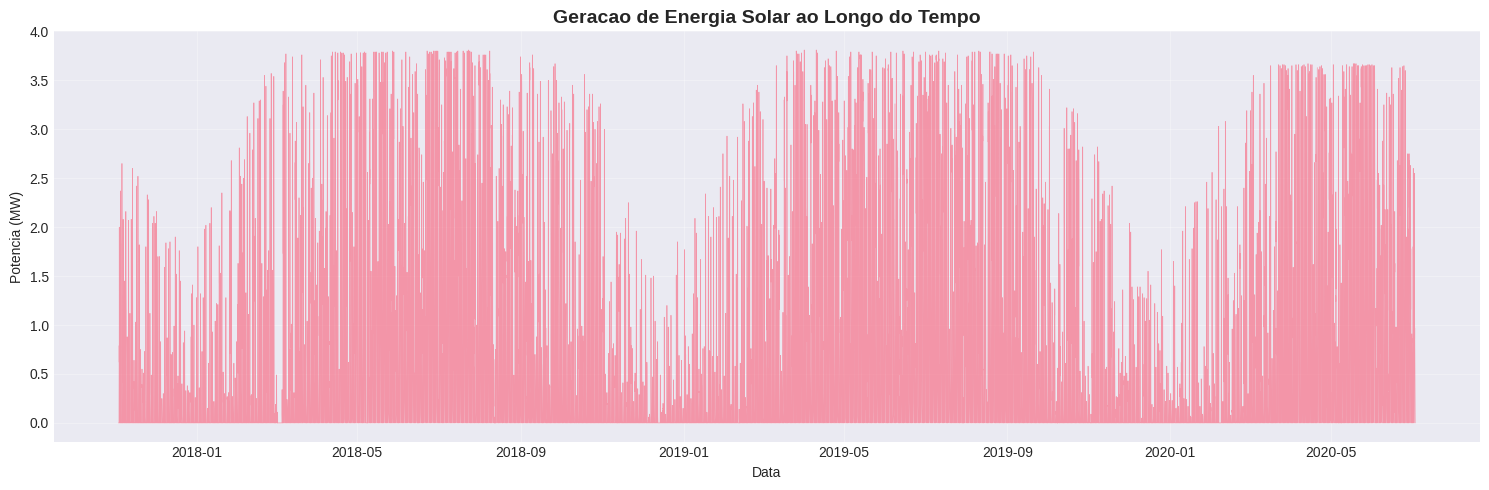

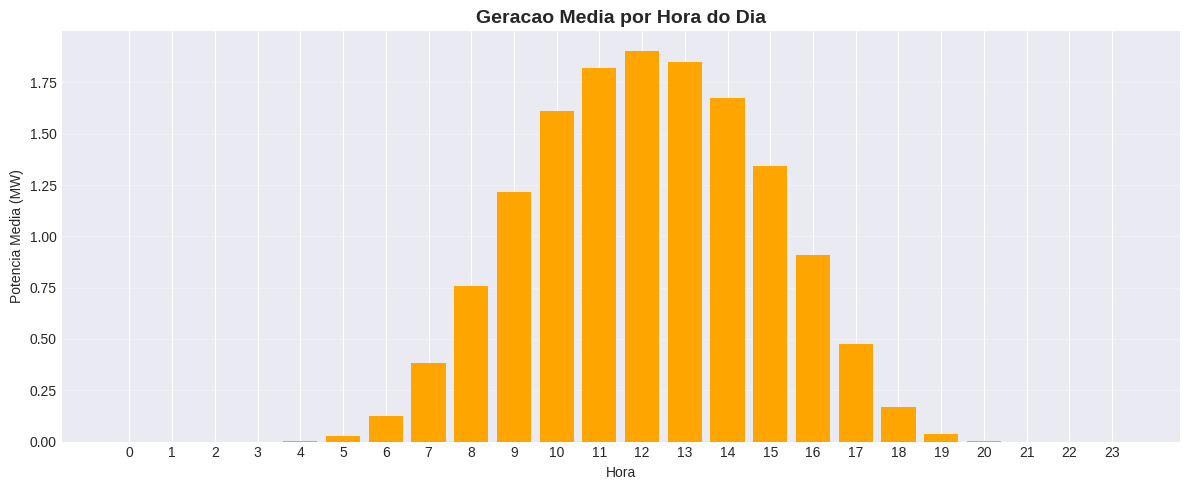

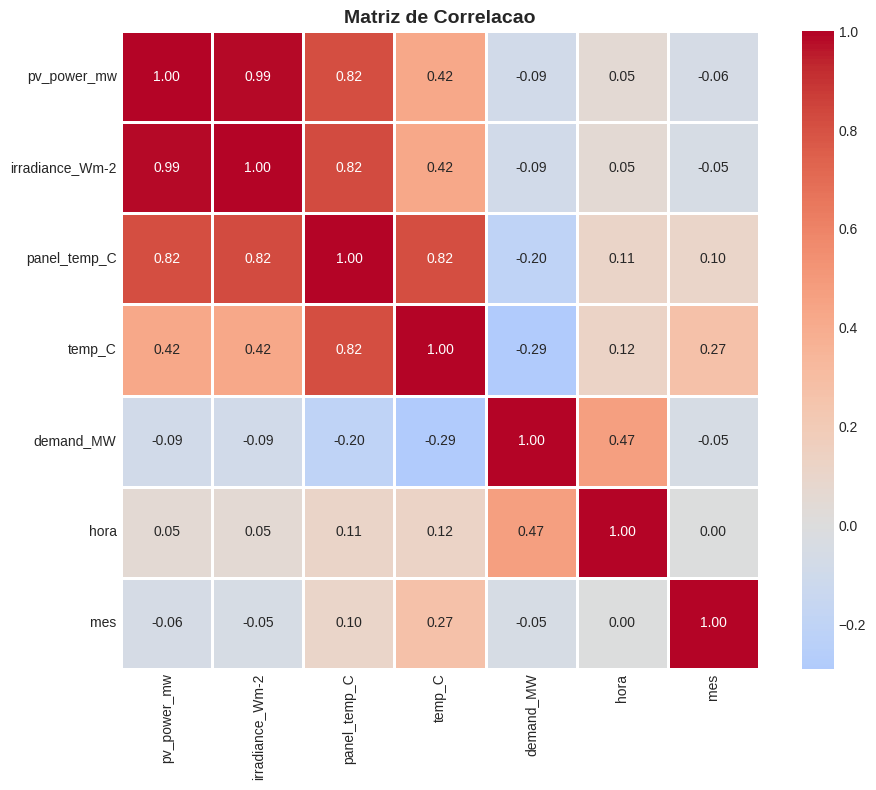


Correlacoes mais fortes com pv_power_mw:
pv_power_mw        1.000000
irradiance_Wm-2    0.987482
panel_temp_C       0.818359
temp_C             0.424436
hora               0.054403
mes               -0.057813
demand_MW         -0.089930
Name: pv_power_mw, dtype: float64


In [124]:
# ============================================================================
# VISUALIZACOES INICIAIS
# ============================================================================

print("="*80)
print("VISUALIZACOES INICIAIS")
print("="*80)

# Visualizacao 1: Geração ao longo do tempo
plt.figure(figsize=(15, 5))
plt.plot(df_treino['datetime'], df_treino['pv_power_mw'], alpha=0.7, linewidth=0.5)
plt.title('Geracao de Energia Solar ao Longo do Tempo', fontsize=14, weight='bold')
plt.xlabel('Data')
plt.ylabel('Potencia (MW)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualizacao 2: Geração por hora do dia
plt.figure(figsize=(12, 5))
geracao_por_hora = df_treino.groupby('hora')['pv_power_mw'].mean()
plt.bar(geracao_por_hora.index, geracao_por_hora.values, color='orange')
plt.title('Geracao Media por Hora do Dia', fontsize=14, weight='bold')
plt.xlabel('Hora')
plt.ylabel('Potencia Media (MW)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Visualizacao 3: Correlação entre variáveis
plt.figure(figsize=(10, 8))
colunas_correlacao = ['pv_power_mw', 'irradiance_Wm-2', 'panel_temp_C', 'temp_C',
                      'demand_MW', 'hora', 'mes']
correlation_matrix = df_treino[colunas_correlacao].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.2f')
plt.title('Matriz de Correlacao', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelacoes mais fortes com pv_power_mw:")
print(correlation_matrix['pv_power_mw'].sort_values(ascending=False))


In [125]:
# ============================================================================
# PREPARACAO DOS DADOS PARA MODELAGEM
# ============================================================================

print("="*80)
print("PREPARACAO DOS DADOS PARA MODELAGEM")
print("="*80)

# Selecionar features para o modelo
features = ['irradiance_Wm-2', 'panel_temp_C', 'temp_C', 'hora', 'mes',
            'dia_semana', 'eh_fim_semana']
target = 'pv_power_mw'

print(f"\nFeatures selecionadas: {features}")
print(f"Target: {target}")

# Separar X e y para treino
X_treino = df_treino[features].copy()
y_treino = df_treino[target].copy()

# Verificar se teste tem todas as features
features_disponiveis_teste = [f for f in features if f in df_teste.columns]
print(f"\nFeatures disponiveis no teste: {features_disponiveis_teste}")

X_teste = df_teste[features_disponiveis_teste].copy()
y_teste = df_teste[target].copy()

# Normalizar dados
print("\nNormalizando dados com StandardScaler...")
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste[features_disponiveis_teste])

# Converter de volta para DataFrame para manter nomes
X_treino_scaled = pd.DataFrame(X_treino_scaled, columns=features, index=X_treino.index)
X_teste_scaled = pd.DataFrame(X_teste_scaled, columns=features_disponiveis_teste, index=X_teste.index)

print(f"\nDados preparados:")
print(f"  X_treino: {X_treino_scaled.shape}")
print(f"  y_treino: {y_treino.shape}")
print(f"  X_teste: {X_teste_scaled.shape}")
print(f"  y_teste: {y_teste.shape}")


PREPARACAO DOS DADOS PARA MODELAGEM

Features selecionadas: ['irradiance_Wm-2', 'panel_temp_C', 'temp_C', 'hora', 'mes', 'dia_semana', 'eh_fim_semana']
Target: pv_power_mw

Features disponiveis no teste: ['irradiance_Wm-2', 'panel_temp_C', 'temp_C', 'hora', 'mes', 'dia_semana', 'eh_fim_semana']

Normalizando dados com StandardScaler...

Dados preparados:
  X_treino: (23352, 7)
  y_treino: (23352,)
  X_teste: (336, 7)
  y_teste: (336,)


In [126]:
# ============================================================================
# TREINAMENTO DE MODELOS - RANDOM FOREST
# ============================================================================

print("="*80)
print("TREINAMENTO - RANDOM FOREST")
print("="*80)

# Treinar Random Forest
print("\nTreinando Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_treino_scaled, y_treino)

y_pred_rf = rf_model.predict(X_teste_scaled)

mae_rf = mean_absolute_error(y_teste, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_teste, y_pred_rf))
r2_rf = r2_score(y_teste, y_pred_rf)

print(f"\nResultados Random Forest:")
print(f"  - MAE (Mean Absolute Error): {mae_rf:.4f} MW")
print(f"  - RMSE (Root Mean Squared Error): {rmse_rf:.4f} MW")
print(f"  - R² (Coeficiente de Determinacao): {r2_rf:.4f}")

# Feature importance
print("\nImportancia das Features:")
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)

TREINAMENTO - RANDOM FOREST

Treinando Random Forest Regressor...

Resultados Random Forest:
  - MAE (Mean Absolute Error): 0.0536 MW
  - RMSE (Root Mean Squared Error): 0.1297 MW
  - R² (Coeficiente de Determinacao): 0.9814

Importancia das Features:
           feature  importance
0  irradiance_Wm-2    0.986151
1     panel_temp_C    0.004622
2           temp_C    0.003427
4              mes    0.002877
3             hora    0.001903
5       dia_semana    0.000953
6    eh_fim_semana    0.000066


In [127]:
# ============================================================================
# TREINAMENTO DE MODELOS - XGBOOST
# ============================================================================

print("="*80)
print("TREINAMENTO - GRADIENT BOOSTING")
print("="*80)

# Treinar Gradient Boosting
print("\nTreinando Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_treino_scaled, y_treino)

y_pred_gb = gb_model.predict(X_teste_scaled)

mae_gb = mean_absolute_error(y_teste, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_teste, y_pred_gb))
r2_gb = r2_score(y_teste, y_pred_gb)

print(f"\nResultados Gradient Boosting:")
print(f"  MAE: {mae_gb:.4f} MW")
print(f"  RMSE: {rmse_gb:.4f} MW")
print(f"  R²: {r2_gb:.4f}")


TREINAMENTO - GRADIENT BOOSTING

Treinando Gradient Boosting Regressor...

Resultados Gradient Boosting:
  MAE: 0.0513 MW
  RMSE: 0.1271 MW
  R²: 0.9822


COMPARACAO DE MODELOS

Tabela Comparativa:
           Modelo      MAE     RMSE       R²
    Random Forest 0.053590 0.129672 0.981449
Gradient Boosting 0.051316 0.127102 0.982177

Melhor modelo: Gradient Boosting (R² = 0.9822)


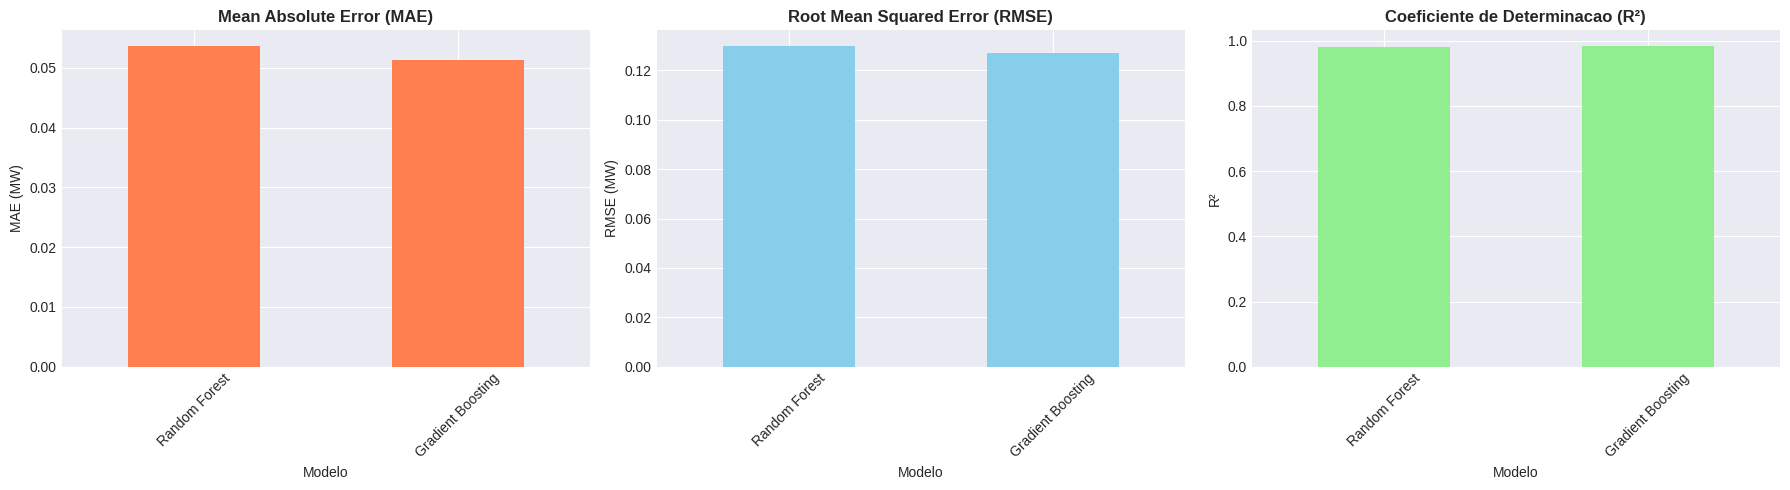

In [128]:
# ============================================================================
# COMPARACAO DE MODELOS
# ============================================================================

print("="*80)
print("COMPARACAO DE MODELOS")
print("="*80)

resultados = pd.DataFrame({
    'Modelo': ['Random Forest', 'Gradient Boosting'],
    'MAE': [mae_rf, mae_gb],
    'RMSE': [rmse_rf, rmse_gb],
    'R²': [r2_rf, r2_gb]
})

print("\nTabela Comparativa:")
print(resultados.to_string(index=False))

# Identificar melhor modelo
melhor_modelo_idx = resultados['R²'].idxmax()
melhor_modelo_nome = resultados.loc[melhor_modelo_idx, 'Modelo']
melhor_r2 = resultados.loc[melhor_modelo_idx, 'R²']

print(f"\nMelhor modelo: {melhor_modelo_nome} (R² = {melhor_r2:.4f})")

# Selecionar melhor modelo para usar
if melhor_modelo_nome == 'Random Forest':
    modelo_final = rf_model
    y_pred_final = y_pred_rf
else:
    modelo_final = gb_model
    y_pred_final = y_pred_gb

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
resultados.plot(x='Modelo', y='MAE', kind='bar', ax=axes[0], color='coral', legend=False)
axes[0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
axes[0].set_ylabel('MAE (MW)')
axes[0].tick_params(axis='x', rotation=45)

# RMSE
resultados.plot(x='Modelo', y='RMSE', kind='bar', ax=axes[1], color='skyblue', legend=False)
axes[1].set_title('Root Mean Squared Error (RMSE)', fontweight='bold')
axes[1].set_ylabel('RMSE (MW)')
axes[1].tick_params(axis='x', rotation=45)

# R²
resultados.plot(x='Modelo', y='R²', kind='bar', ax=axes[2], color='lightgreen', legend=False)
axes[2].set_title('Coeficiente de Determinacao (R²)', fontweight='bold')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


VISUALIZACAO DAS PREDIÇÕES


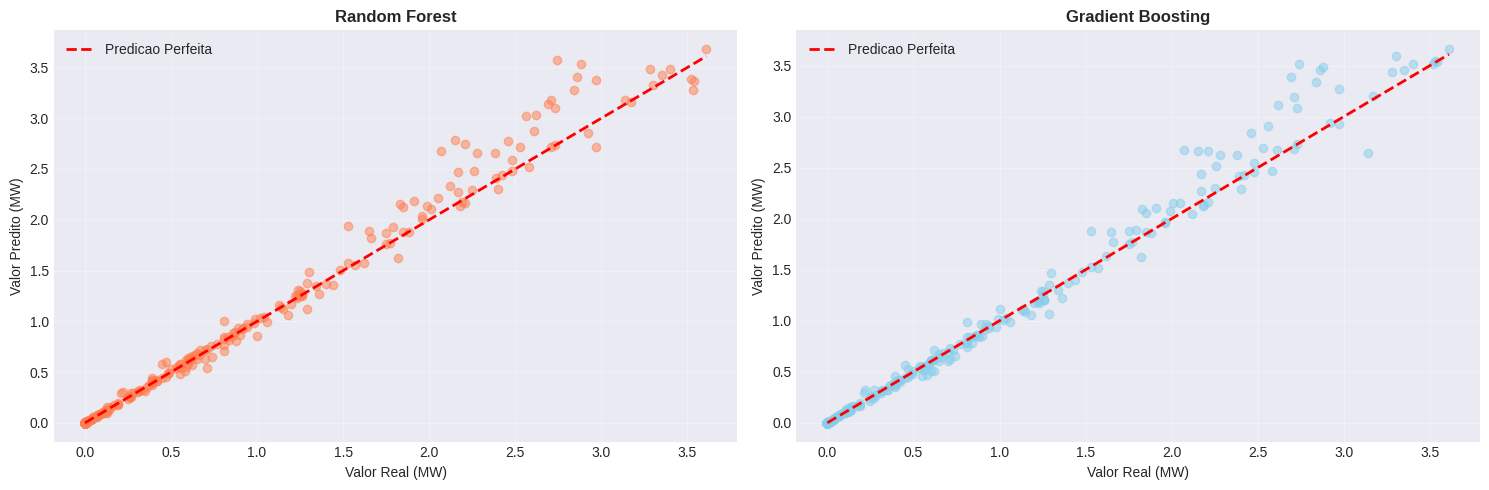

In [129]:
# ============================================================================
# VISUALIZACAO DAS PREDICOES
# ============================================================================

print("="*80)
print("VISUALIZACAO DAS PREDIÇÕES")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Random Forest
axes[0].scatter(y_teste, y_pred_rf, alpha=0.5, color='coral')
axes[0].plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()],
             'r--', lw=2, label='Predicao Perfeita')
axes[0].set_xlabel('Valor Real (MW)')
axes[0].set_ylabel('Valor Predito (MW)')
axes[0].set_title('Random Forest', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gradient Boosting
axes[1].scatter(y_teste, y_pred_gb, alpha=0.5, color='skyblue')
axes[1].plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()],
             'r--', lw=2, label='Predicao Perfeita')
axes[1].set_xlabel('Valor Real (MW)')
axes[1].set_ylabel('Valor Predito (MW)')
axes[1].set_title('Gradient Boosting', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


SISTEMA DE LOGICA FUZZY

Definindo variaveis fuzzy...
  Variaveis fuzzy definidas com sucesso

Definindo regras fuzzy...
  Sistema fuzzy criado com 8 regras


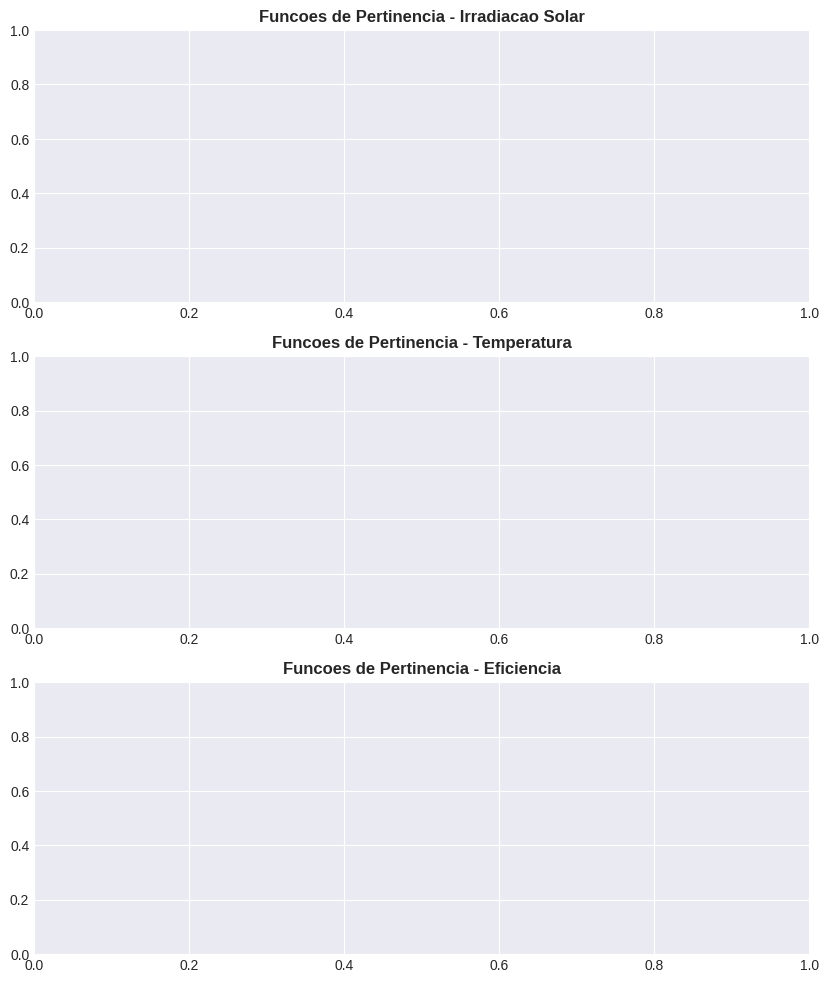

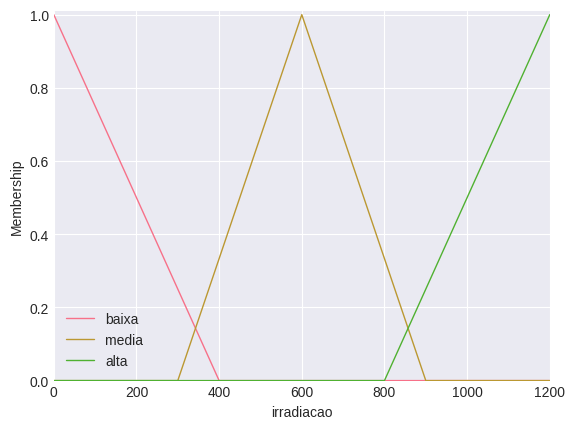

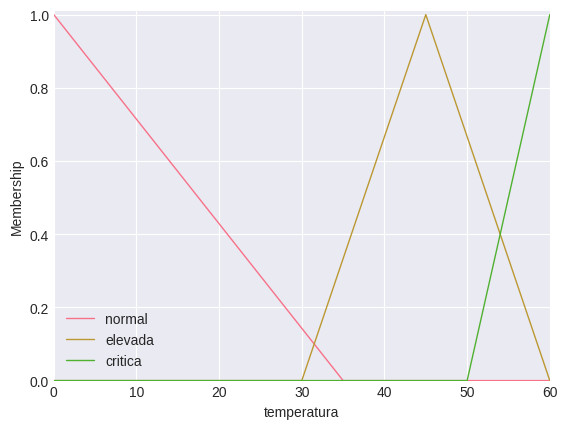

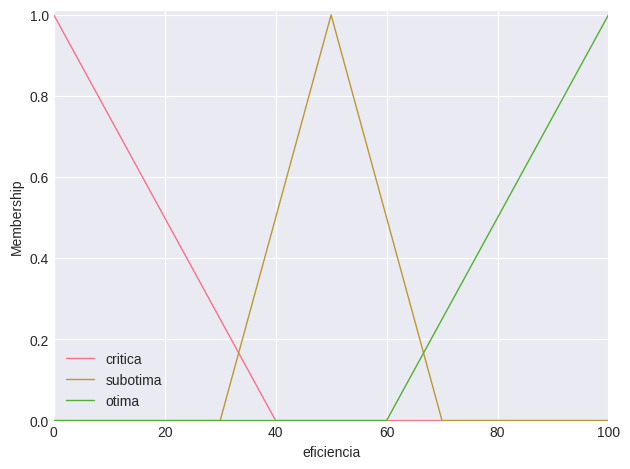

In [130]:
# ============================================================================
# SISTEMA DE LOGICA FUZZY
# ============================================================================

print("="*80)
print("SISTEMA DE LOGICA FUZZY")
print("="*80)

print("\nDefinindo variaveis fuzzy...")

# Variavel 1: Irradiacao Solar (entrada)
irradiacao = ctrl.Antecedent(np.arange(0, 1201, 1), 'irradiacao')
irradiacao['baixa'] = fuzz.trimf(irradiacao.universe, [0, 0, 400])
irradiacao['media'] = fuzz.trimf(irradiacao.universe, [300, 600, 900])
irradiacao['alta'] = fuzz.trimf(irradiacao.universe, [800, 1200, 1200])

# Variavel 2: Temperatura do Painel (entrada)
temperatura = ctrl.Antecedent(np.arange(0, 61, 1), 'temperatura')
temperatura['normal'] = fuzz.trimf(temperatura.universe, [0, 0, 35])
temperatura['elevada'] = fuzz.trimf(temperatura.universe, [30, 45, 60])
temperatura['critica'] = fuzz.trimf(temperatura.universe, [50, 60, 60])

# Variavel 3: Eficiencia (saida)
eficiencia = ctrl.Consequent(np.arange(0, 101, 1), 'eficiencia')
eficiencia['critica'] = fuzz.trimf(eficiencia.universe, [0, 0, 40])
eficiencia['subotima'] = fuzz.trimf(eficiencia.universe, [30, 50, 70])
eficiencia['otima'] = fuzz.trimf(eficiencia.universe, [60, 100, 100])

print("  Variaveis fuzzy definidas com sucesso")

# Definir regras fuzzy
print("\nDefinindo regras fuzzy...")
regra1 = ctrl.Rule(irradiacao['alta'] & temperatura['normal'], eficiencia['otima'])
regra2 = ctrl.Rule(irradiacao['media'] & temperatura['normal'], eficiencia['subotima'])
regra3 = ctrl.Rule(irradiacao['baixa'], eficiencia['critica'])
regra4 = ctrl.Rule(temperatura['critica'], eficiencia['critica'])
regra5 = ctrl.Rule(irradiacao['alta'] & temperatura['elevada'], eficiencia['subotima'])
regra6 = ctrl.Rule(irradiacao['media'] & temperatura['elevada'], eficiencia['subotima'])
regra7 = ctrl.Rule(irradiacao['baixa'] & temperatura['elevada'], eficiencia['critica'])
regra8 = ctrl.Rule(irradiacao['media'] & temperatura['critica'], eficiencia['critica'])

# Criar sistema de controle
sistema_eficiencia = ctrl.ControlSystem([regra1, regra2, regra3, regra4,
                                          regra5, regra6, regra7, regra8])
simulador_eficiencia = ctrl.ControlSystemSimulation(sistema_eficiencia)

print("  Sistema fuzzy criado com 8 regras")

# Visualizar funcoes de pertinencia
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

irradiacao.view(ax=axes[0])
axes[0].set_title('Funcoes de Pertinencia - Irradiacao Solar', fontweight='bold')

temperatura.view(ax=axes[1])
axes[1].set_title('Funcoes de Pertinencia - Temperatura', fontweight='bold')

eficiencia.view(ax=axes[2])
axes[2].set_title('Funcoes de Pertinencia - Eficiencia', fontweight='bold')

plt.tight_layout()
plt.show()

In [131]:
# ============================================================================
# SISTEMA DE RECOMENDACOES
# ============================================================================

print("="*80)
print("SISTEMA DE RECOMENDACOES")
print("="*80)

# Funcao para classificar eficiencia com fuzzy
def classificar_eficiencia(irrad, temp):
    try:
        simulador_eficiencia.input['irradiacao'] = irrad
        simulador_eficiencia.input['temperatura'] = temp
        simulador_eficiencia.compute()
        return simulador_eficiencia.output['eficiencia']
    except:
        return 50

# Funcao para gerar recomendacoes
def gerar_recomendacao(geracao_prevista_mw, eficiencia_score, irradiacao, temperatura, consumo_esperado_mw=5.0):
    if eficiencia_score >= 70:
        categoria_eficiencia = "OTIMA"
        emoji_status = "[OTIMA]"
    elif eficiencia_score >= 40:
        categoria_eficiencia = "SUB-OTIMA"
        emoji_status = "[SUB-OTIMA]"
    else:
        categoria_eficiencia = "CRITICA"
        emoji_status = "[CRITICA]"

    excedente = geracao_prevista_mw - consumo_esperado_mw

    print("\n" + "="*70)
    print(f"STATUS: {emoji_status}")
    print("="*70)
    print(f"\nDados do Sistema:")
    print(f"  Geracao Prevista: {geracao_prevista_mw:.2f} MW")
    print(f"  Consumo Esperado: {consumo_esperado_mw:.2f} MW")
    print(f"  Excedente/Deficit: {excedente:.2f} MW")
    print(f"  Irradiacao: {irradiacao:.1f} W/m²")
    print(f"  Temperatura Painel: {temperatura:.1f}°C")
    print(f"  Eficiencia: {categoria_eficiencia} ({eficiencia_score:.1f}/100)")

    print(f"\nRecomendacoes:")

    if categoria_eficiencia == "OTIMA" and excedente > 1:
        print("  [+] Excelente momento! Sistema operando em capacidade maxima")
        print("  [+] Armazene o excedente em baterias para uso noturno")
        print("  [+] Considere vender excedente para a rede eletrica")
        print("  [+] Momento ideal para uso de equipamentos de alto consumo")
        print(f"  [$] Economia estimada: R$ {excedente * 0.75 * 1000:.2f}/hora")

    elif categoria_eficiencia == "SUB-OTIMA":
        print("  [!] Geracao moderada detectada")
        print("  [!] Use energia conscientemente")
        print("  [!] Evite ligar multiplos equipamentos simultaneamente")
        if excedente > 0:
            print(f"  [+] Pequeno excedente disponivel: {excedente:.2f} MW")
        else:
            print(f"  [-] Deficit previsto: {abs(excedente):.2f} MW")
            print(f"  [$] Custo adicional da rede: R$ {abs(excedente) * 0.75 * 1000:.2f}/hora")

    else:
        print("  [!!] ALERTA: Geracao abaixo do esperado")
        print("  [!!] Utilize energia da bateria se disponivel")
    print("="*70 + "\n")

SISTEMA DE RECOMENDACOES


In [132]:
# ============================================================================
# SIMULACAO E TESTE FINAL
# ============================================================================

print("="*80)
print("SIMULACAO E TESTE FINAL")
print("="*80)

# --- Exemplo de teste ---
# 1. Pegar um ponto de dados do conjunto de teste (X_teste)
# Usaremos o primeiro ponto para o exemplo.
ponto_teste = X_teste_scaled.iloc[0]
dados_reais = df_teste.iloc[0]

# Extrair as features para a previsão do ML
X_exemplo_scaled = ponto_teste.to_frame().T
previsao_mw = modelo_final.predict(X_exemplo_scaled)[0]

# Extrair os dados REAIS de Irradiância e Temperatura para o sistema Fuzzy
irradiacao_real = dados_reais['irradiance_Wm-2']
temperatura_painel_real = dados_reais['panel_temp_C']
consumo_real = dados_reais['demand_MW']

# 2. Calcular a Eficiência Fuzzy
eficiencia_score = classificar_eficiencia(irradiacao_real, temperatura_painel_real)

# 3. Gerar a Recomendacao Final
print(f"\nSIMULACAO PARA O PONTO DE DADOS EM: {dados_reais['datetime']}")
print(f"  -> Irradiacao Real: {irradiacao_real:.1f} W/m²")
print(f"  -> Temperatura Painel Real: {temperatura_painel_real:.1f}°C")
print(f"  -> Consumo Real (Usado como Consumo Esperado): {consumo_real:.2f} MW")

# Usar o consumo real para a recomendação
gerar_recomendacao(
    geracao_prevista_mw=previsao_mw,
    eficiencia_score=eficiencia_score,
    irradiacao=irradiacao_real,
    temperatura=temperatura_painel_real,
    consumo_esperado_mw=consumo_real
)

# --- Exemplo 2: Cenário de Manhã/Noite (Irradiância Baixa) ---
irrad_ex2 = 50       # Baixa
temp_ex2 = 15        # Normal
consumo_ex2 = 2.0    # Consumo baixo
# Previsão ML de 0.1 MW (Assumindo que o ML prevê zero/quase zero para este horário)
previsao_ex2 = 0.1

eficiencia_ex2 = classificar_eficiencia(irrad_ex2, temp_ex2)

print("\nSIMULACAO 2: Cenário de Manhã Cedo (Baixa Irradiância)")
gerar_recomendacao(
    geracao_prevista_mw=previsao_ex2,
    eficiencia_score=eficiencia_ex2,
    irradiacao=irrad_ex2,
    temperatura=temp_ex2,
    consumo_esperado_mw=consumo_ex2
)

# --- Exemplo 3: Cenário de Calor (Temperatura Crítica) ---
irrad_ex3 = 1100      # Alta
temp_ex3 = 55         # Crítica
consumo_ex3 = 4.5     # Consumo Moderado
# Previsão ML de 7.5 MW (Um pouco abaixo do máximo devido ao calor)
previsao_ex3 = 7.5

eficiencia_ex3 = classificar_eficiencia(irrad_ex3, temp_ex3)

print("\nSIMULACAO 3: Cenário de Verão Quente (Irradiância Alta, Temp Crítica)")
gerar_recomendacao(
    geracao_prevista_mw=previsao_ex3,
    eficiencia_score=eficiencia_ex3,
    irradiacao=irrad_ex3,
    temperatura=temp_ex3,
    consumo_esperado_mw=consumo_ex3
)

print("\n" + "="*80)
print("PROJETO FINALIZADO COM SUCESSO!")
print("="*80)


SIMULACAO E TESTE FINAL

SIMULACAO PARA O PONTO DE DADOS EM: 2020-07-03 00:00:00
  -> Irradiacao Real: 0.0 W/m²
  -> Temperatura Painel Real: 8.2°C
  -> Consumo Real (Usado como Consumo Esperado): 1.64 MW

STATUS: [CRITICA]

Dados do Sistema:
  Geracao Prevista: -0.00 MW
  Consumo Esperado: 1.64 MW
  Excedente/Deficit: -1.64 MW
  Irradiacao: 0.0 W/m²
  Temperatura Painel: 8.2°C
  Eficiencia: CRITICA (13.3/100)

Recomendacoes:
  [!!] ALERTA: Geracao abaixo do esperado
  [!!] Utilize energia da bateria se disponivel


SIMULACAO 2: Cenário de Manhã Cedo (Baixa Irradiância)

STATUS: [CRITICA]

Dados do Sistema:
  Geracao Prevista: 0.10 MW
  Consumo Esperado: 2.00 MW
  Excedente/Deficit: -1.90 MW
  Irradiacao: 50.0 W/m²
  Temperatura Painel: 15.0°C
  Eficiencia: CRITICA (13.5/100)

Recomendacoes:
  [!!] ALERTA: Geracao abaixo do esperado
  [!!] Utilize energia da bateria se disponivel


SIMULACAO 3: Cenário de Verão Quente (Irradiância Alta, Temp Crítica)

STATUS: [CRITICA]

Dados do Sistem